In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from helpers import style
import statsmodels.api as sm
from matplotlib.gridspec import GridSpec
from helpers.afa import adaptive_filter
from itertools import groupby
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from collections import defaultdict
import networkx as nx

from helpers.linkage import mutual_information_smooth
from helpers import nwsim
from helpers.metrics import *
from helpers.metrics import foote_novelty
import matplotlib.gridspec as gridspec

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

In [2]:
dists, dat, ct, keys, dz = load(zscore_filter=True)

# Topic Linkage Network Neigbor Similarity

If topics specialize, it could be expected that their network neighbours are increasingly similar over time.

In [24]:
from helpers.metrics import *
from cdlib import algorithms
from helpers.visuals import plot_trend

In [4]:
networks = {}

for cd,(date, _) in enumerate(dists.groupby(dists.index)):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr='pmi')
    networks[date] = g

In [5]:
# Neigbourhood Similarity with Overlap Coefficient
r = []
for t in set(dists.columns.astype(int).map(keys)):
     r += [{"t":t,"p1": p1, "p2": p2,'ovl':overlap_coefficient(set(c1.neighbors(t)),set(c2.neighbors(t)))}
          for p1, c1 in networks.items() for p2, c2 in networks.items() if p1 != p2]

rd = pd.DataFrame(r)

In [6]:
# Look back at the previous four period and calculate mean overlap
ps = sorted(rd.p1.unique())
rdt=rd[rd.p1.apply(lambda per: ps.index(per)) == rd.p2.apply(lambda per: ps.index(per)) - 1]

rr = []
window = 4
for t,d in rdt.groupby('t'):
    vls = d.ovl.tolist()
    dts = pd.to_datetime(d.p1,infer_datetime_format=True).tolist()
    for i in range(window,len(d)):
        lb = np.mean(vls[i-window:i])
        rr.append({"t":t,"d":dts[i],"lbv":lb})
rrd = pd.DataFrame(rr)
rrd = rrd[pd.to_datetime(rrd.d,infer_datetime_format=True) < pd.Timestamp(year=1994,month=6,day=1)]

In [13]:
rrdm = rrd.groupby('d').lbv.mean().reset_index()

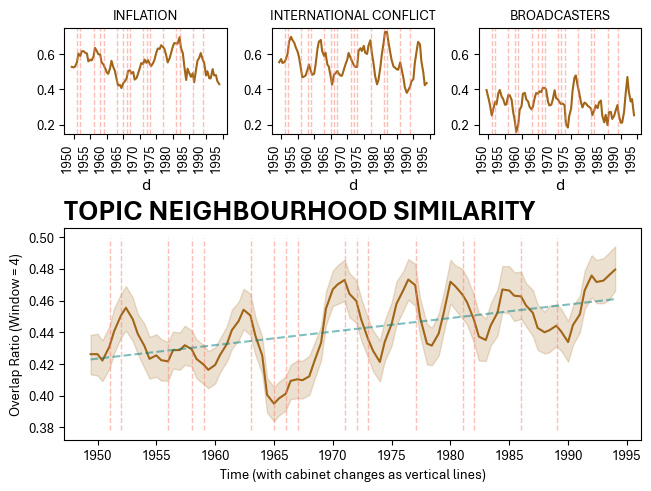

In [25]:
from helpers.visuals import add_cabinet_periods

fig = plt.figure(layout="constrained")

gs = GridSpec(3, 9, figure=fig)
ax1 = fig.add_subplot(gs[1:, :])

ax2 = fig.add_subplot(gs[0, 0:3])
ax3 = fig.add_subplot(gs[0, 3:6])
ax4 = fig.add_subplot(gs[0, 6:9])

rrd[rrd.t == 'inflation'].plot(x='d',y='lbv',ax=ax2,legend=False,title='INFLATION',ylim=(.15,.75))
rrd[rrd.t == 'international conflict'].plot(x='d',y='lbv',ax=ax3,legend=False,title='INTERNATIONAL CONFLICT',ylim=(.15,.75))
rrd[rrd.t == 'broadcasters'].plot(x='d',y='lbv',ax=ax4,legend=False,title='BROADCASTERS',ylim=(.15,.75))
add_cabinet_periods(ax2,min_time=1950,max_time=1994,text=False)
add_cabinet_periods(ax3,min_time=1950,max_time=1994,text=False)
add_cabinet_periods(ax4,min_time=1950,max_time=1994,text=False)

sns.lineplot(data=rrd,x='d',y='lbv',ax=ax1)
add_cabinet_periods(ax1,min_time=1950,max_time=1994,text=False)
plot_trend(rrd.d,rrd.lbv,ax=ax1,color='teal',alpha=.5,ls='--')


ax2.xaxis.set_tick_params(rotation=90)
ax3.xaxis.set_tick_params(rotation=90)
ax4.xaxis.set_tick_params(rotation=90)

ax1.set_title('TOPIC NEIGHBOURHOOD SIMILARITY',fontweight='bold',fontsize=20,loc='left')
ax1.set_ylabel('Overlap Ratio (Window = 4)',fontsize=10)
ax1.set_xlabel('Time (with cabinet changes as vertical lines)',fontsize=10)
plt.savefig('figs/nbh-similarity.png',dpi=400)
plt.show()

In [8]:
rrd['d'] = pd.to_datetime(rrd.d,infer_datetime_format=True)
dd = dists.groupby(dists.index).mean().rename(columns={c:keys[int(c)] for c in dists.columns})

<Axes: xlabel='date'>

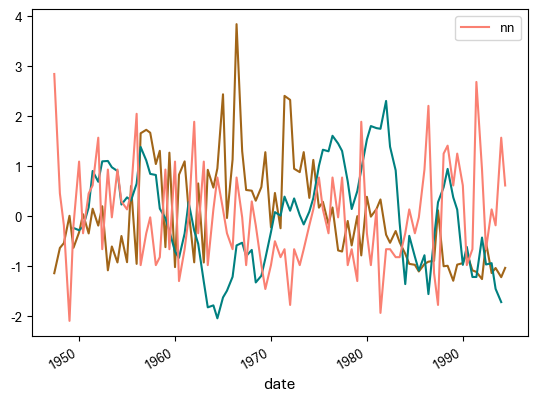

In [9]:
t = 'inflation'
f,a = plt.subplots()
a.plot(dd.index,zscore(dd[t]))
ss = rrd[rrd.t == t]
a.plot(ss.d,zscore(ss.lbv),color='teal')
nn = pd.DataFrame({date:len(list(_.neighbors(t))) / len(g.nodes) for date,_ in networks.items()}.items(),columns=['date','nn'])
nn['nn'] = zscore(nn.nn)
nn.plot(ax=a,x='date',y='nn',color='salmon')